#  Forecasting the number of sold for Indian spices  
We will forecast the number of sold goods in the city of Bangalore (India)

## 1. Подготовительный этап

### 1.1 Импорт библиотек, данных

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression

import warnings
warnings.filterwarnings('ignore')

In [3]:
# sales data in India in various cities and states
df = pd.read_csv("https://raw.githubusercontent.com/aiedu-courses/stepik_applied_tasks/main/datasets/market_arrivals_ind.csv")

df.date = pd.DatetimeIndex(df.date)

# sort and add date to the index
df = df.sort_values(by="date")
df.index = pd.PeriodIndex(df.date, freq="M")

In [4]:
# we need only 'quantity' column, drop another
df_bang = df.loc[df.city == "BANGALORE"].copy()

# df_bang column's names convert to drop list
drop_list = list(df_bang.columns)
drop_list.remove('quantity')
print(drop_list)

# drop columns
ts = df_bang.drop(drop_list, axis=1)

ts.head()

['market', 'month', 'year', 'priceMin', 'priceMax', 'priceMod', 'state', 'city', 'date']


,quantity
date,
2004-01,227832
2004-02,225133
2004-03,221952
2004-04,185150
2004-05,137390


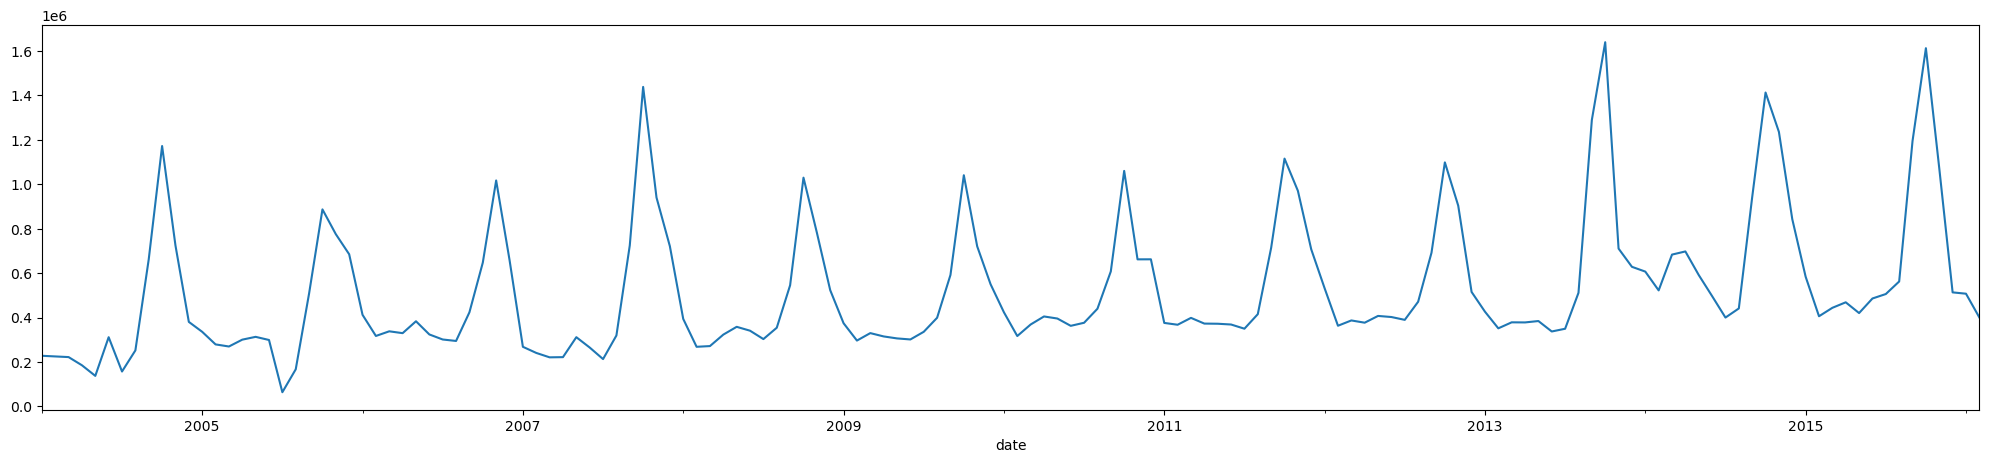

In [5]:
ts.quantity.plot(figsize=(25,5));

## 2. Data preprocessing

### 2.1 Create new TS features

In [6]:
# add lag features at first
for i in range(1, 12):
    ts[f"lag_{i}"] = ts.quantity.shift(i)

ts.dropna(inplace=True)
    
print(ts[1:12])

         quantity     lag_1     lag_2      lag_3      lag_4      lag_5  \
date                                                                     
2005-01    335679  380379.0  724140.0  1171846.0   662382.0   251984.0   
2005-02    279047  335679.0  380379.0   724140.0  1171846.0   662382.0   
2005-03    269609  279047.0  335679.0   380379.0   724140.0  1171846.0   
2005-04    300428  269609.0  279047.0   335679.0   380379.0   724140.0   
2005-05    313052  300428.0  269609.0   279047.0   335679.0   380379.0   
2005-06    298906  313052.0  300428.0   269609.0   279047.0   335679.0   
2005-07     63824  298906.0  313052.0   300428.0   269609.0   279047.0   
2005-08    166881   63824.0  298906.0   313052.0   300428.0   269609.0   
2005-09    508155  166881.0   63824.0   298906.0   313052.0   300428.0   
2005-10    886683  508155.0  166881.0    63824.0   298906.0   313052.0   
2005-11    775223  886683.0  508155.0   166881.0    63824.0   298906.0   

             lag_6      lag_7      la

### 2.2 Split train & test df

In [10]:
# split
split_index = int(0.85*len(ts))

train = ts[:split_index]
test = ts[split_index:]

print(f'Train shape is {train.shape} and test shape is {test.shape}')

Train shape is (114, 12) and test shape is (21, 12)


In [11]:
# stand out X y
y_train = train['quantity']
y_test = test['quantity']

X_train = train.drop('quantity', axis=1)
X_test = test.drop('quantity', axis=1)

### 2.3 Create agregating features

Previously I used pivot tables to create aggregate attributes like average for the day, but now I found a way to do it more laconic.

In [12]:
# func create the dictionary with key - feature name, value - aggregated feature
# above we use it for mean value
def code_mean(data, cat_feature, real_feature):
    return dict(data.groupby(cat_feature)[real_feature].mean())

In [13]:
# check it on month mean
ts['month'] = ts.index.month
mean_dict = code_mean(ts,'month','quantity')

display(mean_dict)

{1: 436629.0833333333,
 2: 344012.0,
 3: 371731.36363636365,
 4: 380720.8181818182,
 5: 385653.45454545453,
 6: 362042.2727272727,
 7: 326113.2727272727,
 8: 397590.54545454547,
 9: 748347.7272727273,
 10: 1179873.8181818181,
 11: 889838.5454545454,
 12: 615578.75}

## 3.0 Baseline

CPU times: user 18.5 ms, sys: 2.38 ms, total: 20.9 ms
Wall time: 39.9 ms


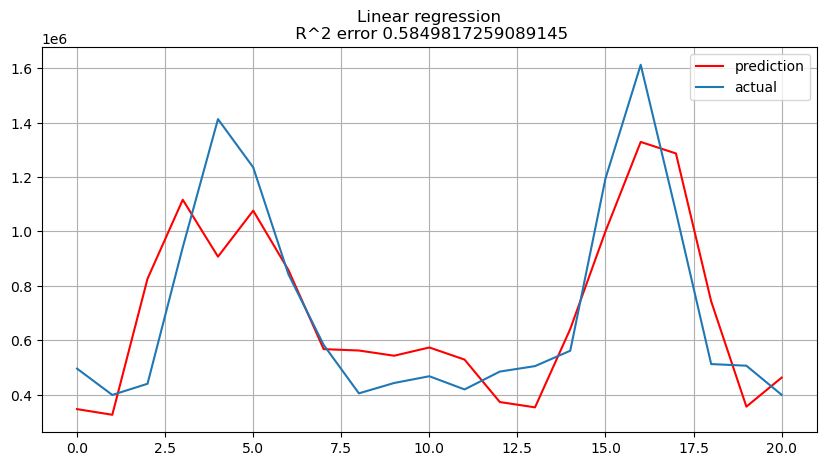

In [14]:
%%time

# declare the regression model
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)

plt.figure(figsize=(10, 5))
plt.plot(y_pred, "r", label="prediction")
plt.plot(y_test.values, label="actual")
plt.grid(True)
plt.legend(loc="best")
plt.title(f"Linear regression\n R^2 error {r2_score(y_pred, y_test)}");

## 3.1 Model improvement